In [1]:
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from ydc.tools import import_data, distances
from ydc.tools.supercats import add_supercats
from ydc.tools.cache import cache_result
from simplekml import Kml, Style
from colorsys import hsv_to_rgb
import matplotlib.pylab as pylab
from os import path, makedirs
pylab.rcParams['figure.figsize'] = 12, 6  # that's default image size for this interactive session

In [2]:
reviews = import_data.import_reviews(fields=['business_id', 'date', 'stars'], status=True)

Successfully imported reviews with columns ['business_id' 'date' 'stars']


In [5]:
@cache_result('pickles')
def merge_cats(reviews):
    (businesses, box) = add_supercats(import_data.import_businesses(fields=['business_id', 'categories']))
    reviews = pd.merge(reviews, businesses, on='business_id')
    reviews['real_date'] = reviews.apply(lambda row: dt.datetime.strptime(row['date'], '%Y-%m-%d'), axis=1)
    reviews.set_index('real_date', inplace=True)
    return (reviews, businesses, box)

In [6]:
(reviews, businesses, box) = merge_cats(reviews, new_cache=True)

In [7]:
for key in box:
    print("{} is {}".format(key, box[key]['name']))

0 is Event Planning & Services
1 is Shopping
2 is Home Services
3 is Beauty & Spas
4 is Active Life
5 is Restaurants
6 is Automotive
7 is Food
8 is Pets
-1 is Uncategorized


In [8]:
def show_review_changes(reviews, frame_radius=30, days_back=150, step_width=10, max_iterations=1000, title=None):
    steps = range(frame_radius, days_back + 1, step_width)
    seperations = pd.DataFrame(columns=steps)
    
    i = 1
    for bid in set(reviews['business_id'].tolist()):
        print("iteration {} of {}".format(i, max_iterations), end='\r')
        business_reviews = reviews[reviews['business_id'] == bid]
        last_review = business_reviews.index.max()
        for days_in_past in steps:
            sep_date = last_review - dt.timedelta(days=days_in_past)
            first_frame_border = sep_date + dt.timedelta(days=frame_radius)
            last_frame_border = sep_date - dt.timedelta(days=frame_radius)
            
            seperations.loc[bid, days_in_past] = business_reviews[(business_reviews.index >= sep_date) &
                                                           (business_reviews.index <= first_frame_border)]['stars'].mean() \
                - business_reviews[(business_reviews.index < sep_date) & 
                                   (business_reviews.index >= last_frame_border)]['stars'].mean()
        # do not iterate all day long
        if i >= max_iterations:
            break
        i = i + 1
        
    # normalize data
    print("normalize data", end='\r')
    seperation_norm = {}
    seperation_data_count = {}
    for col in seperations.columns.values:
        seperation_norm[col] = np.sum(np.abs(seperations[col].dropna(0))) / seperations[col].count()
        seperation_data_count[col] = seperations[col].count()
    seperation_norm = pd.Series(seperation_norm)
    seperation_data_count = pd.Series(seperation_data_count)
    
    # show plot
    gs = gridspec.GridSpec(3,3)
    fig = plt.figure()
    if title is not None:
        fig.suptitle(title, fontsize=14)
    ax = plt.subplot(gs[0:2, :])
    ax.set_title("Average Star-Difference")
    seperation_norm.plot()
    ax = plt.subplot(gs[-1, :])
    ax.set_title("Number of Reviews")
    seperation_data_count.plot(kind='area')
    plt.show()
    
    # return normalized data
    return seperation_norm

def show_business_review_changes(reviews, bid, frame_radius=30, days_back=150, step_width=10, title=None):
    steps = range(frame_radius, days_back + 1, step_width)
    seperations = pd.DataFrame(columns=steps)
    stars = pd.Series(index=range(0, days_back + 1, step_width))
    
    business_reviews = reviews[reviews['business_id'] == bid]
    last_review = business_reviews.index.max()
    for days_in_past in range(0, frame_radius, step_width):
        sep_date = last_review - dt.timedelta(days=days_in_past)
        stars.loc[days_in_past] = business_reviews[(business_reviews.index > sep_date - dt.timedelta(days=3)) &
                                                   (business_reviews.index < sep_date + dt.timedelta(days=3))]\
            ['stars'].mean()
    for days_in_past in steps:
        sep_date = last_review - dt.timedelta(days=days_in_past)
        first_frame_border = sep_date + dt.timedelta(days=frame_radius)
        last_frame_border = sep_date - dt.timedelta(days=frame_radius)

        seperations.loc[bid, days_in_past] = business_reviews[(business_reviews.index >= sep_date) &
                                                       (business_reviews.index <= first_frame_border)]['stars'].mean() \
            - business_reviews[(business_reviews.index < sep_date) & 
                               (business_reviews.index >= last_frame_border)]['stars'].mean()
        stars.loc[days_in_past] = business_reviews[(business_reviews.index > sep_date - dt.timedelta(days=3)) &
                                                   (business_reviews.index < sep_date + dt.timedelta(days=3))]\
            ['stars'].mean()
        
    # normalize data
    print("normalize data", end='\r')
    seperation_norm = {}
    seperation_data_count = {}
    for col in seperations.columns.values:
        seperation_norm[col] = np.sum(np.abs(seperations[col].dropna(0))) / seperations[col].count()
        seperation_data_count[col] = seperations[col].count()
    seperation_norm = pd.Series(seperation_norm)
    seperation_data_count = pd.Series(seperation_data_count)
    
    # show plot
    gs = gridspec.GridSpec(2,3)
    fig = plt.figure()
    if title is not None:
        fig.suptitle(title, fontsize=14)
    ax = plt.subplot(gs[0, :])
    ax.set_title("Average Star-Difference")
    ax = seperation_norm.plot()
    ax.set_xlim(0, days_back)
    ax = plt.subplot(gs[1, :])
    ax.set_title("stars over time")
    ax = stars.plot()
    ax.set_ylim(1,5)
    ax.set_xlim(0, days_back)
    plt.show()
    
    # return normalized data
    return seperation_norm

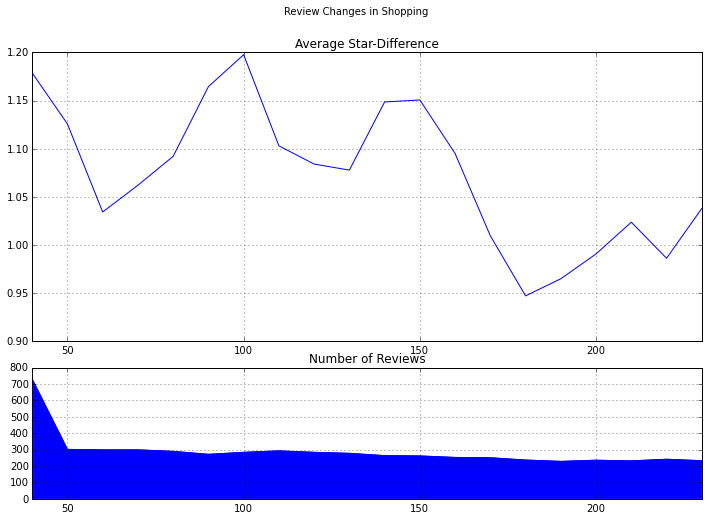

40     1.178663
50     1.125688
60     1.034259
70     1.062035
80     1.092065
90     1.164436
100    1.197598
110    1.102960
120    1.084018
130    1.077758
140    1.148521
150    1.150573
160    1.094983
170    1.009492
180    0.947118
190    0.964904
200    0.990713
210    1.023649
220    0.986198
230    1.037912
dtype: float64

In [97]:
show_review_changes(reviews[reviews['super_category'] == 1], max_iterations=3000, frame_radius=40, step_number=20,
                    title='Review Changes in Shopping')

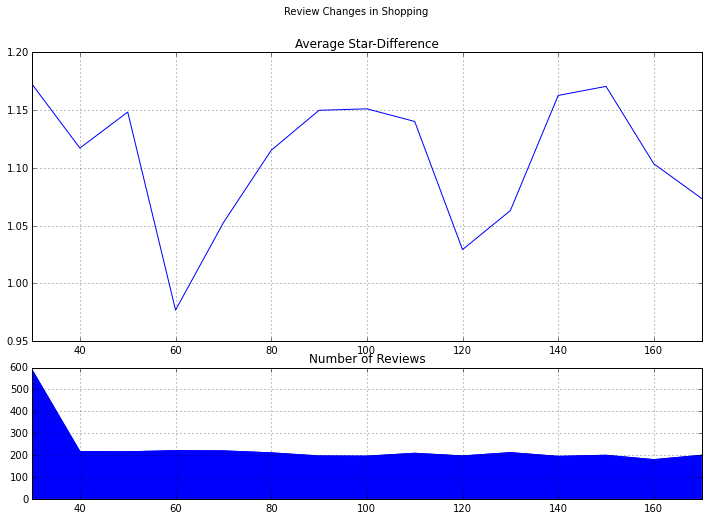

30     1.172405
40     1.117185
50     1.148383
60     0.976984
70     1.052618
80     1.115286
90     1.149883
100    1.151162
110    1.140227
120    1.029312
130    1.063118
140    1.162733
150    1.170597
160    1.103556
170    1.073562
dtype: float64

In [98]:
show_review_changes(reviews[reviews['super_category'] == 1], max_iterations=3000, frame_radius=30, step_number=15,
                    title='Review Changes in Shopping')

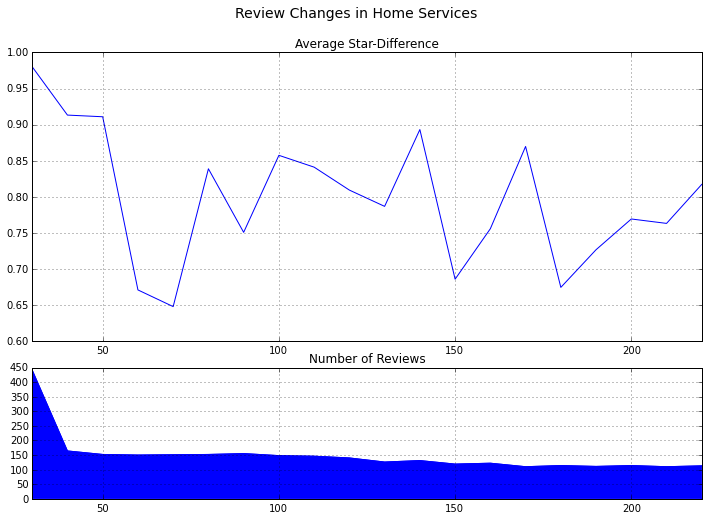

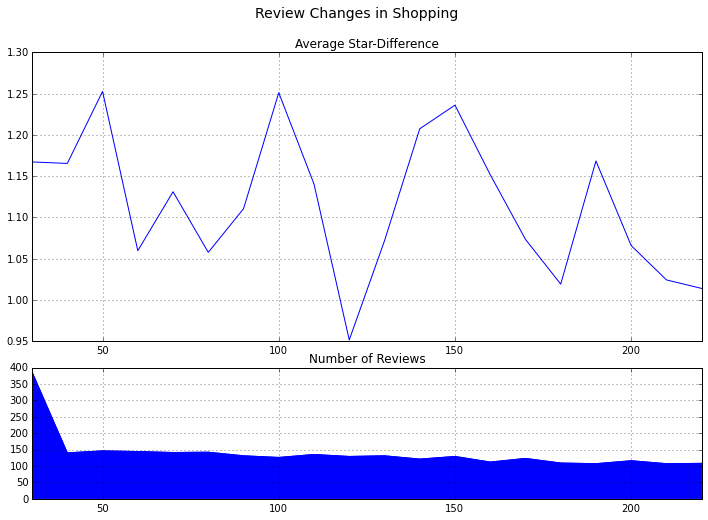

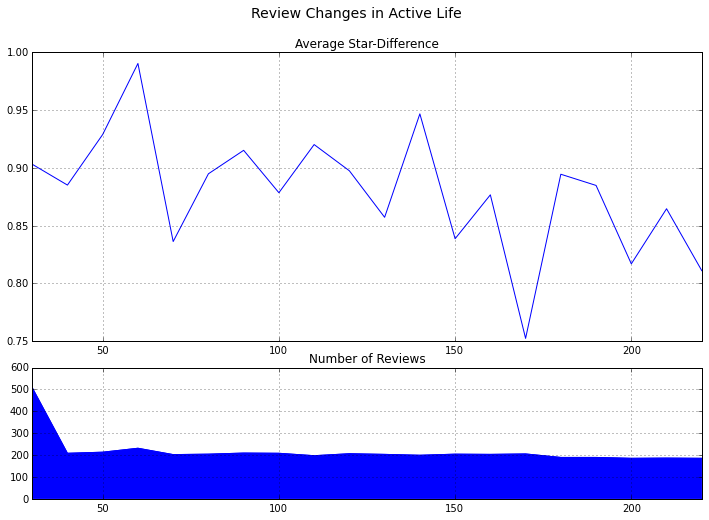

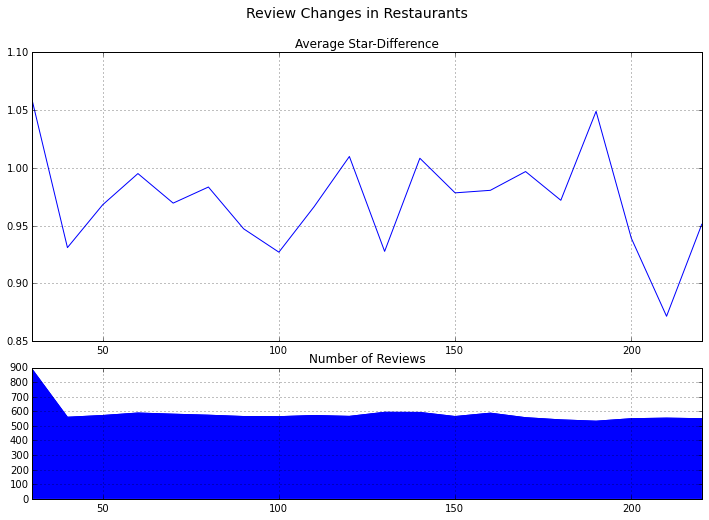

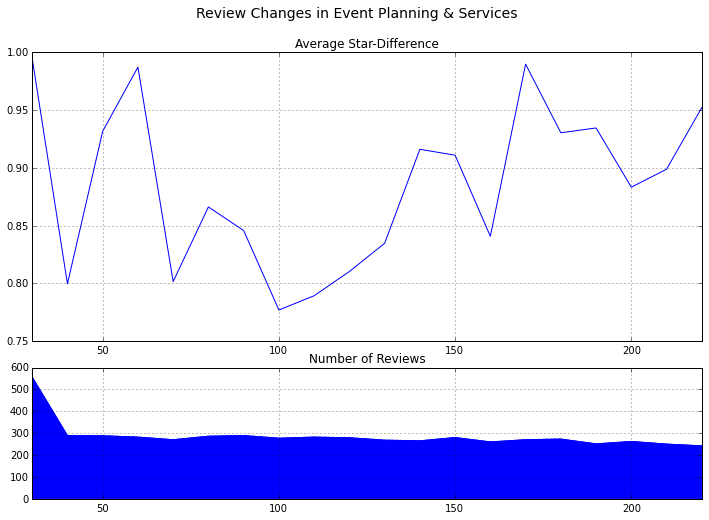

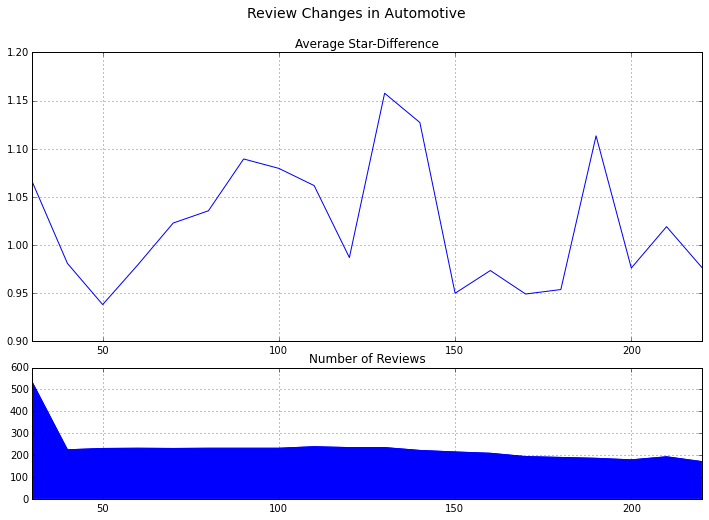

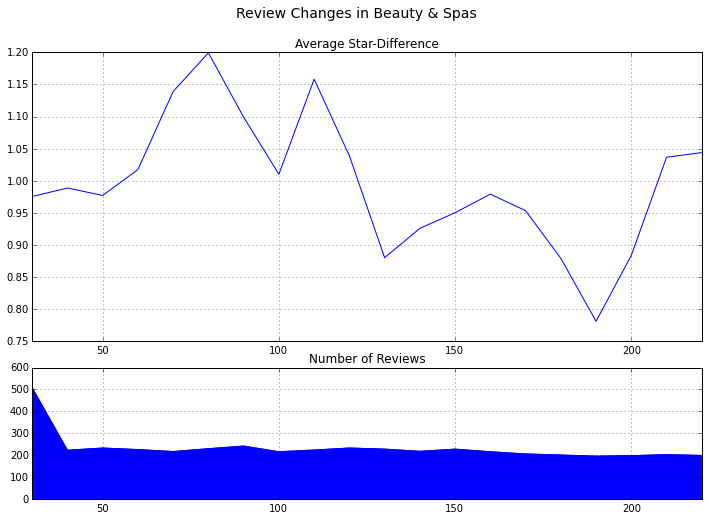

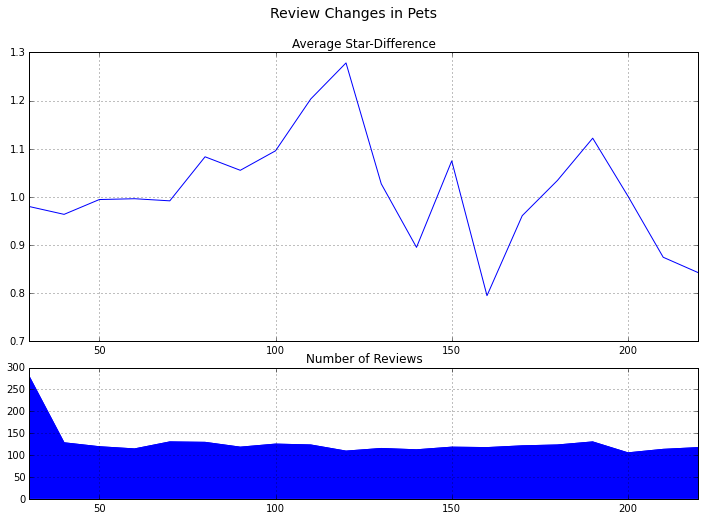

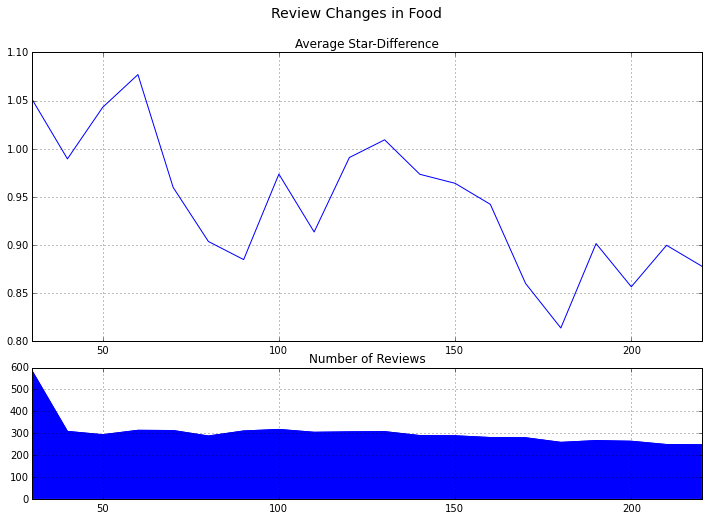

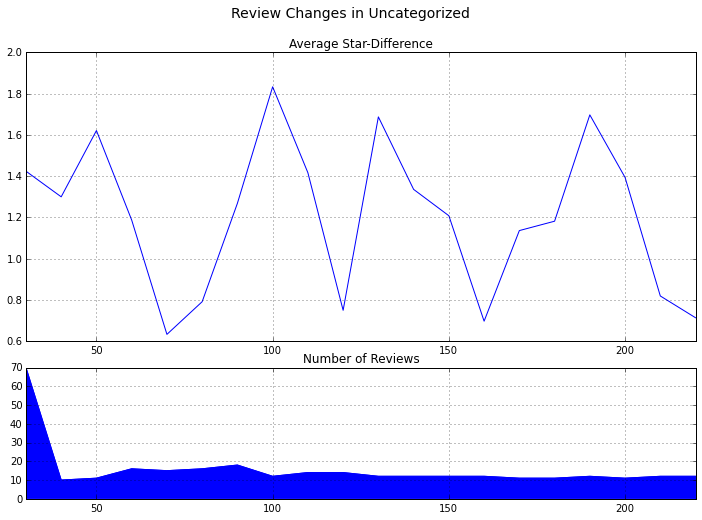

In [101]:
for supercat in box:
    trash = show_review_changes(reviews[reviews['super_category'] == supercat], max_iterations=2000, frame_radius=30,
                                step_number=20,
                                title="Review Changes in " + box[supercat]['name'])

In [152]:
max_iterations = 1000
i = 1
last_review = {}
for bid in set(reviews['business_id'].tolist()):
    print("iteration {} of {}".format(i, max_iterations), end='\r')
    business_reviews = reviews[reviews['business_id'] == bid]
    last_date = business_reviews['real_date'].max()
    last_review[last_date] = last_review.get(last_date, 0) + 1
    if i >= max_iterations:
        break
    i = i + 1
last_review = pd.Series(last_review)

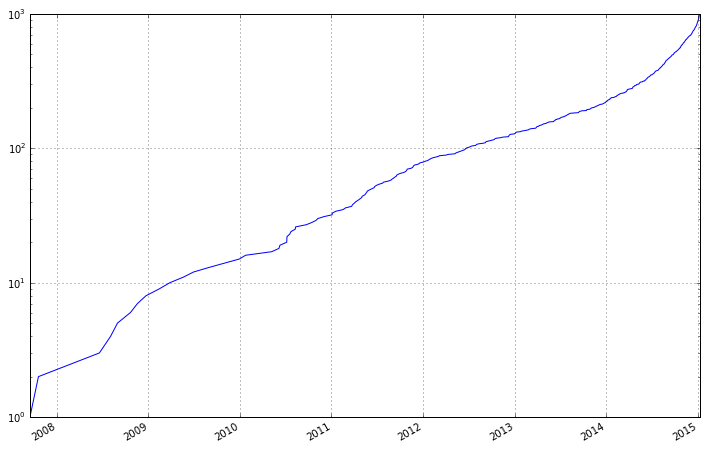

In [155]:
#plt.figure()
#last_review.plot(kind='area')
#plt.show()
plt.figure()
plot = last_review.cumsum()
plot.plot(logy=True)
plt.show()

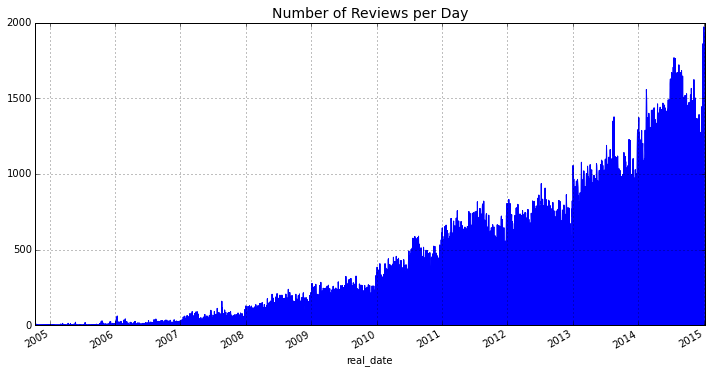

In [221]:
review_distribution = reviews.index.value_counts()
plt.figure()
plt.title("Number of Reviews per Day", fontsize=14)
review_distribution.plot(kind='area')
plt.show()

In [8]:
has_review = set(reviews['business_id'].tolist())

In [7]:
businesses = import_data.import_businesses(fields=['business_id', 'name', 'stars'])

In [10]:
no_review = set(businesses['business_id'].tolist()) - has_review

In [11]:
len(no_review)

399

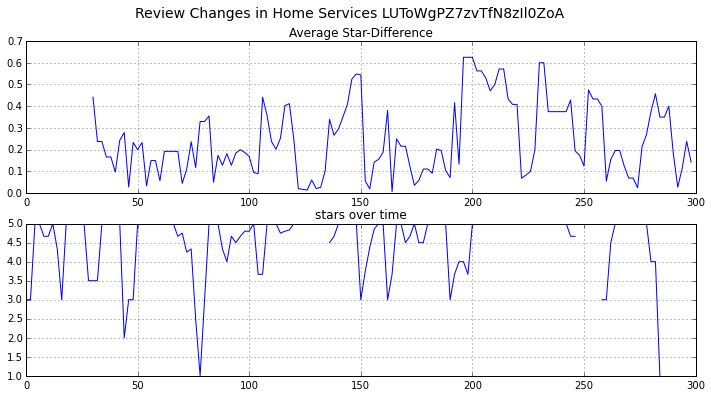

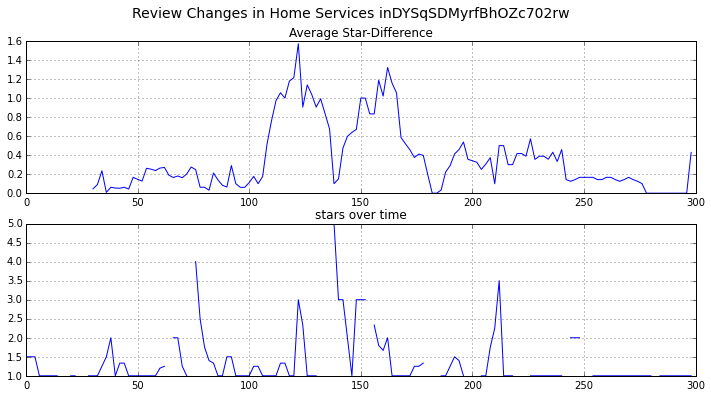

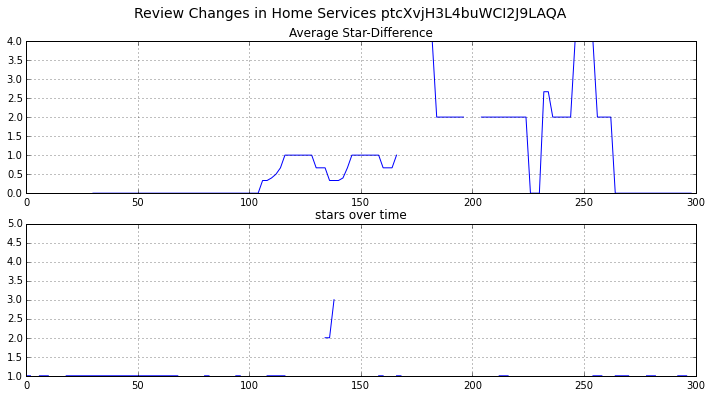

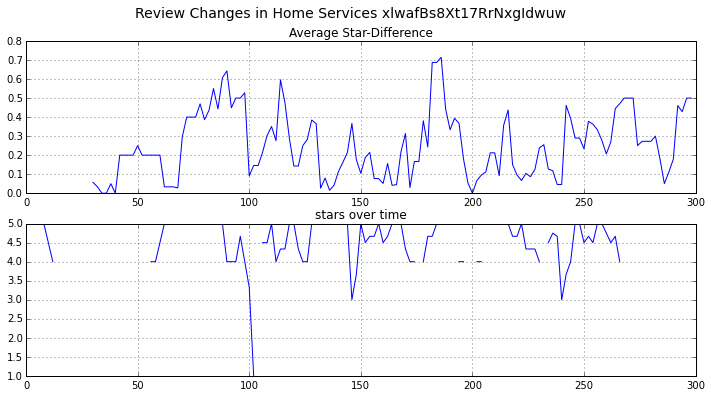

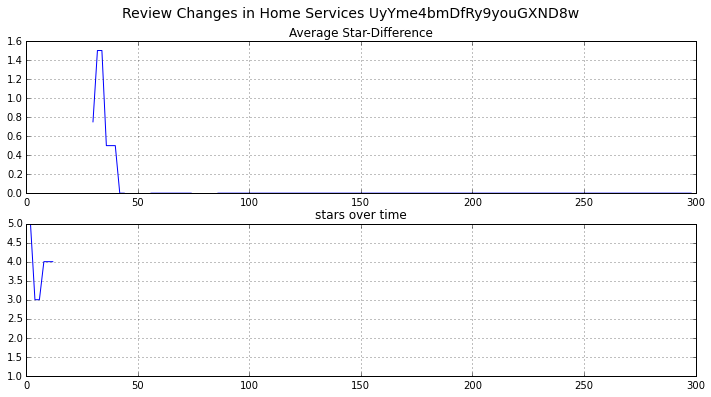

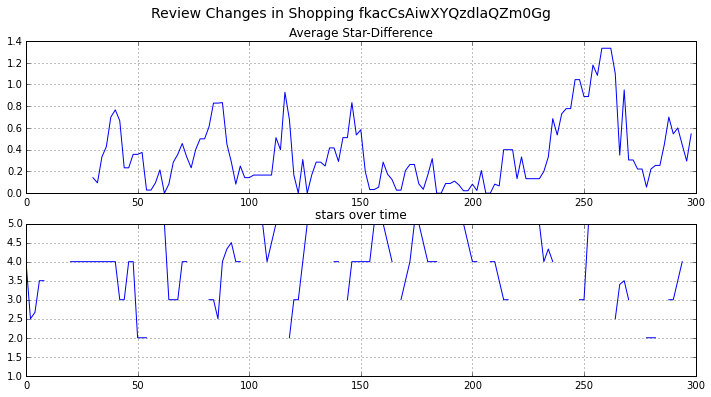

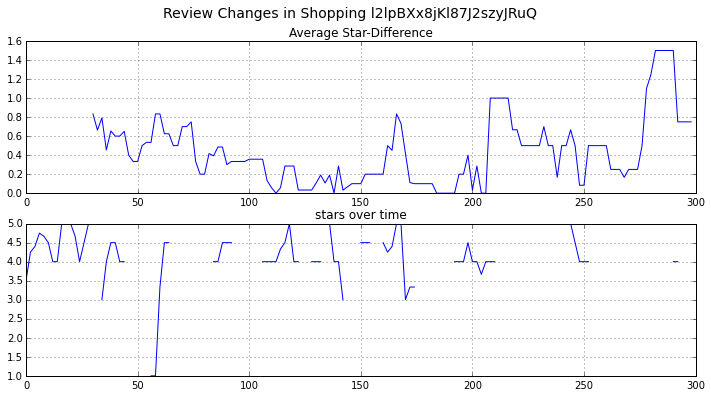

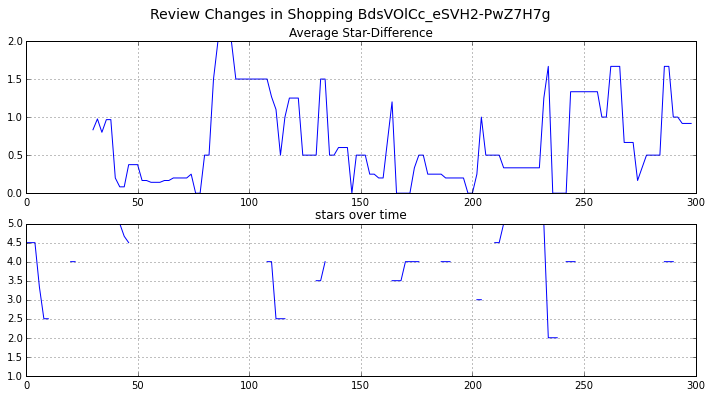

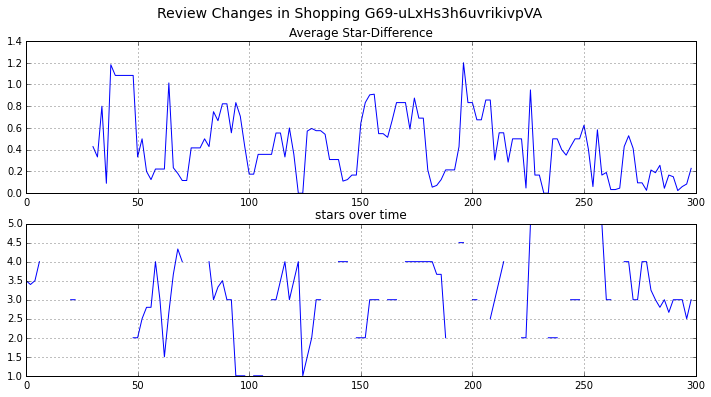

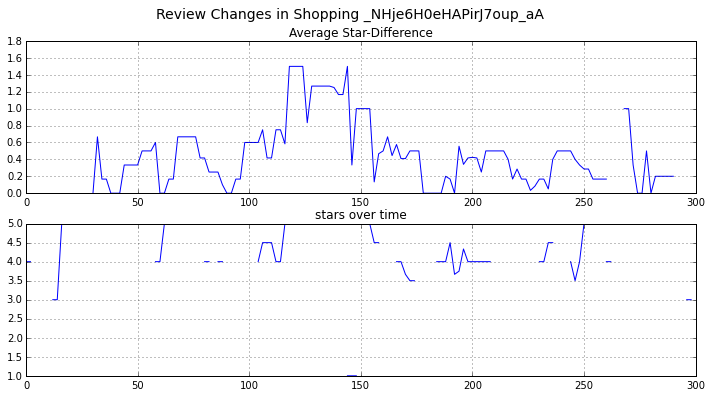

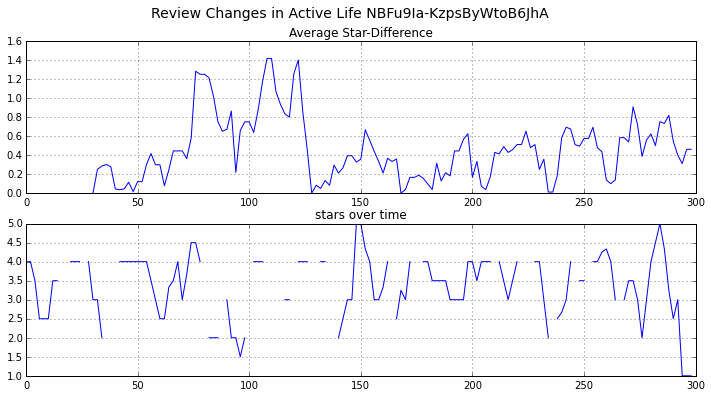

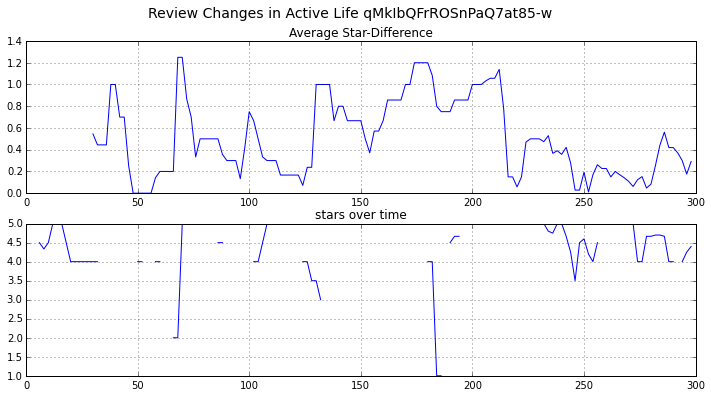

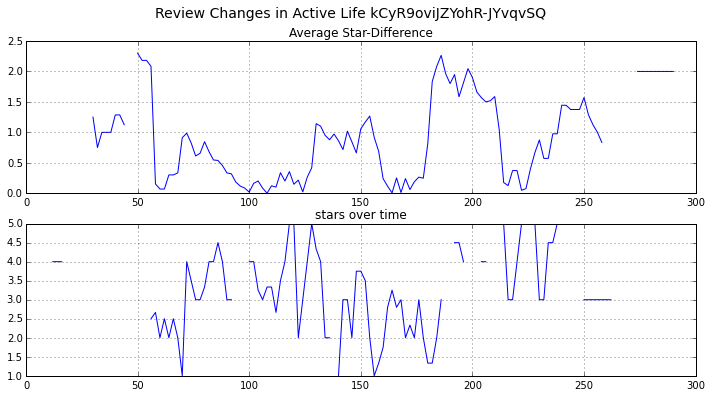

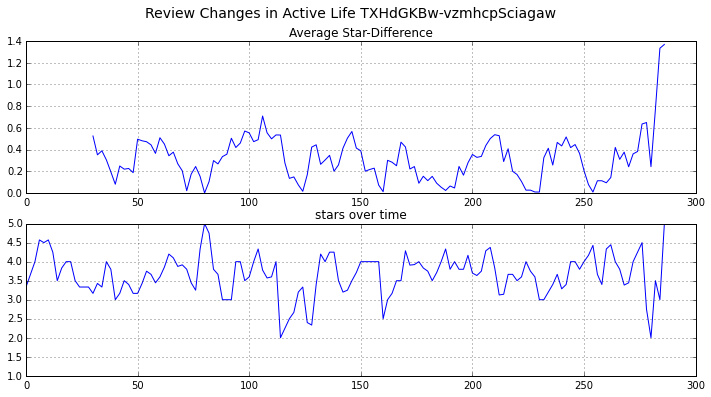

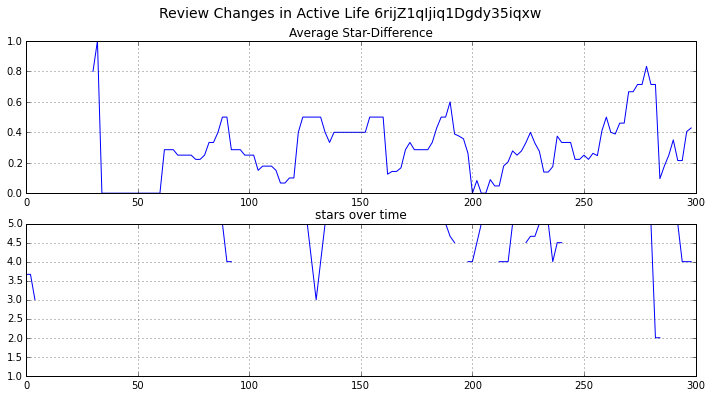

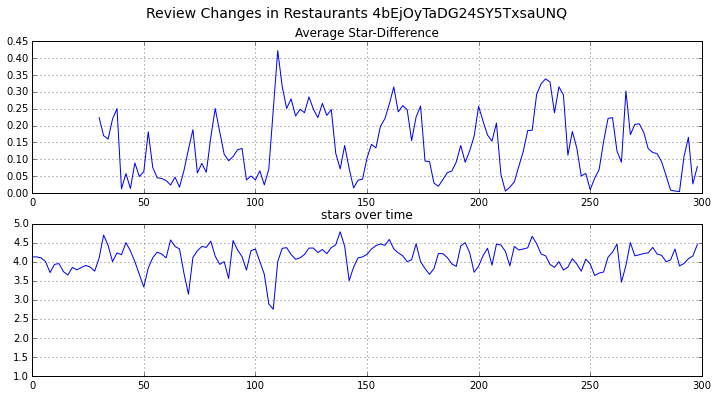

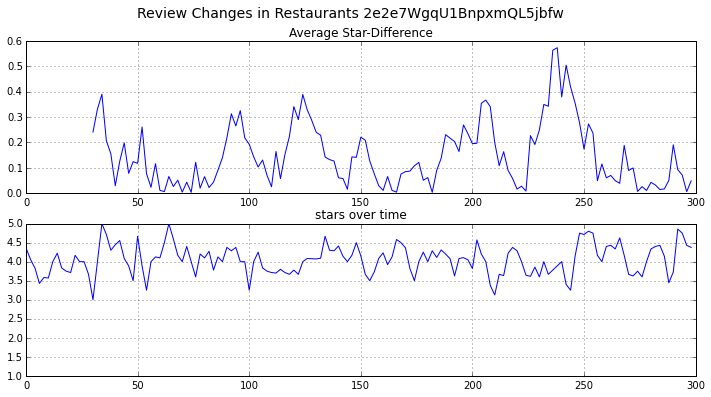

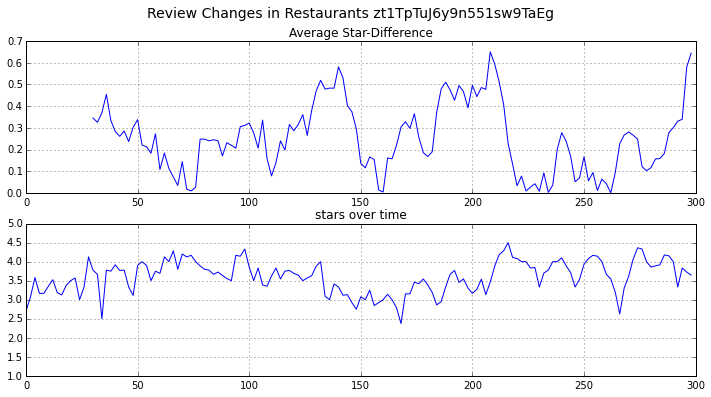

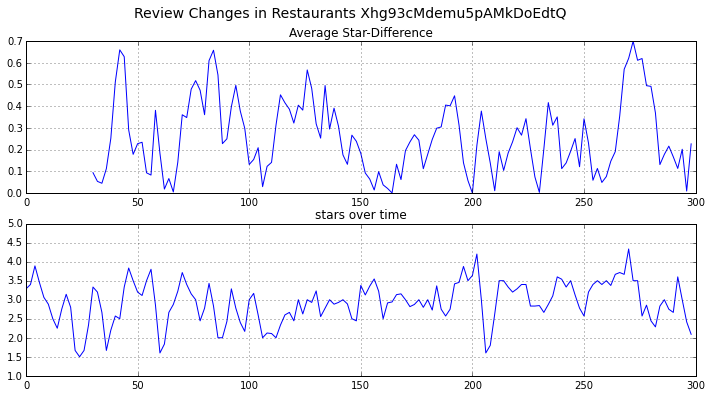

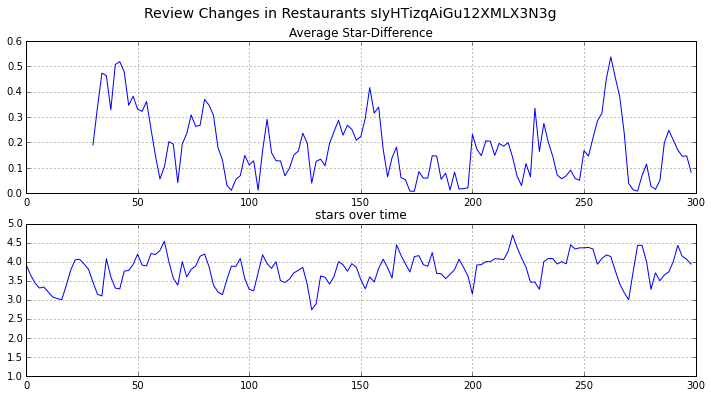

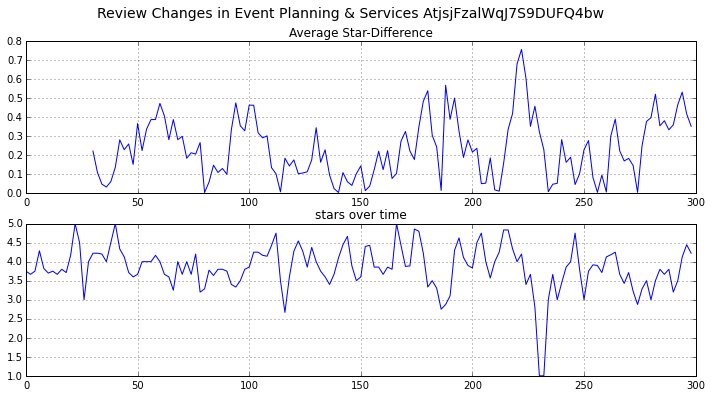

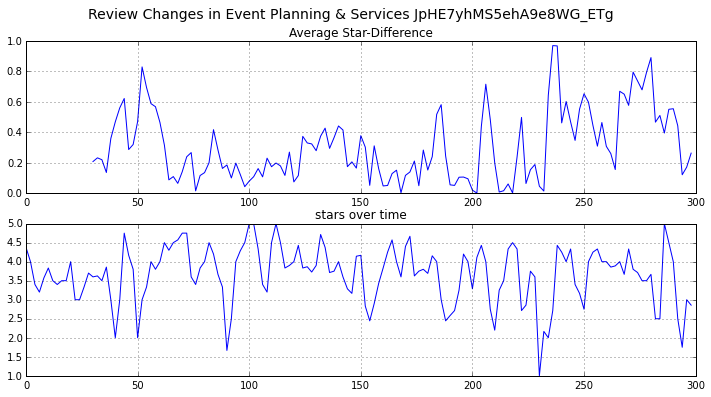

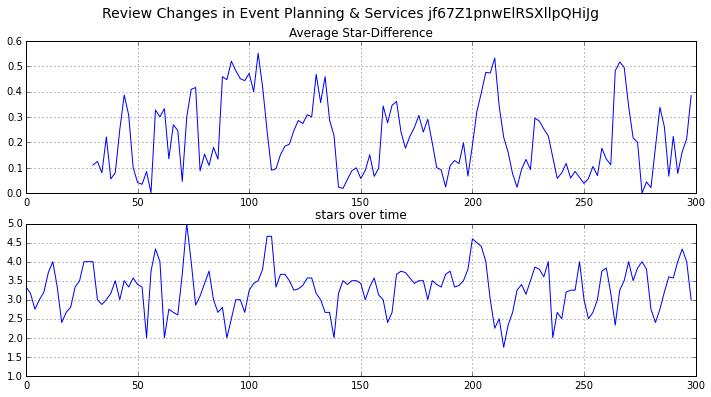

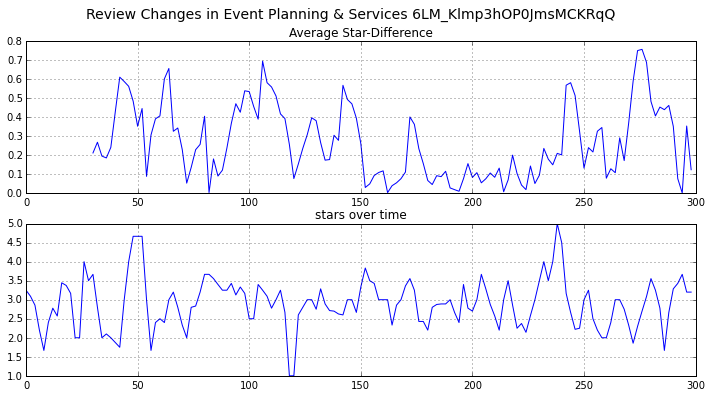

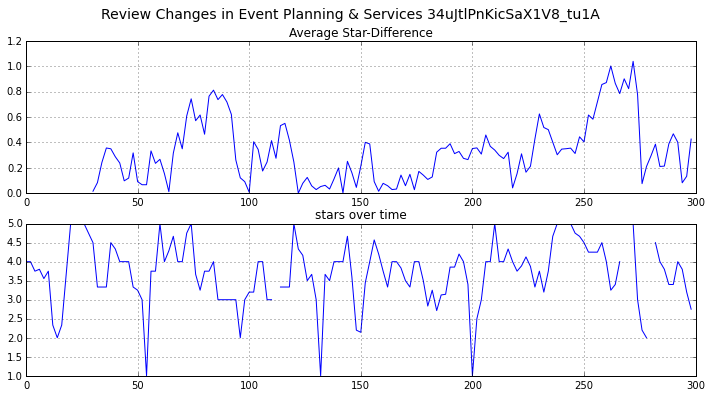

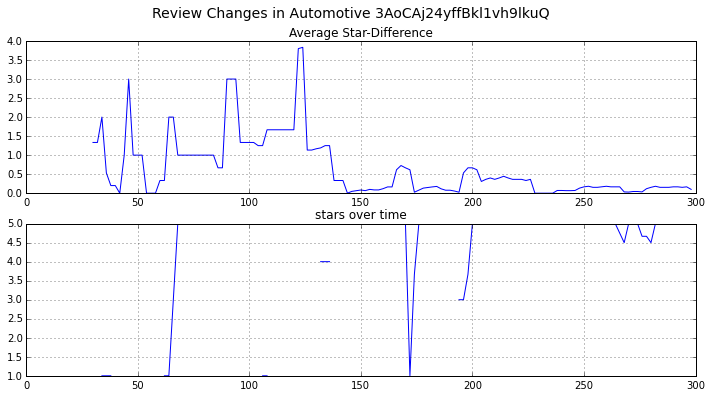

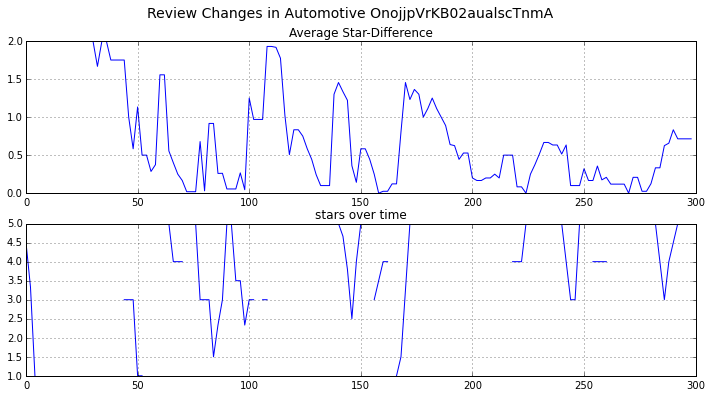

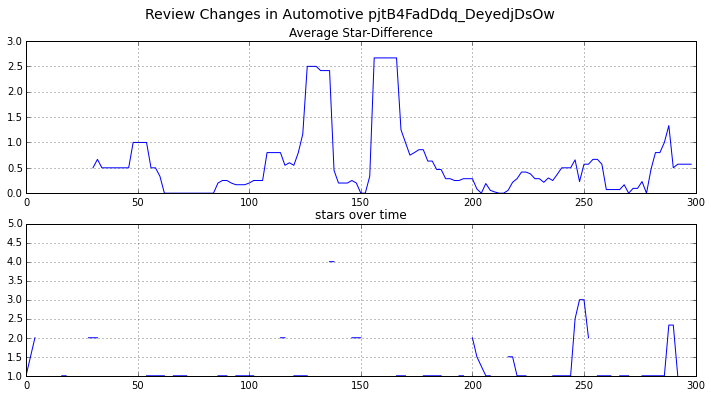

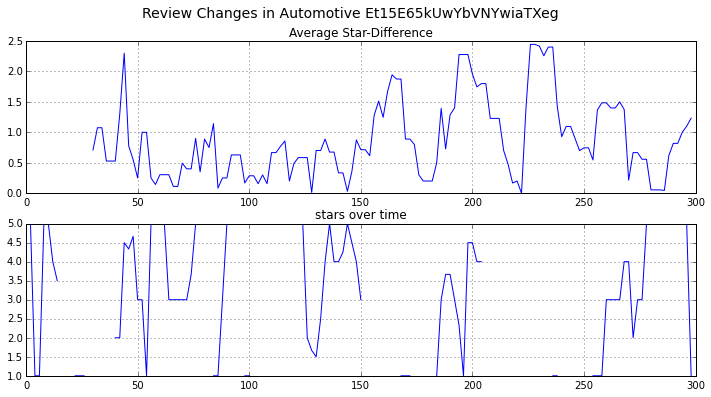

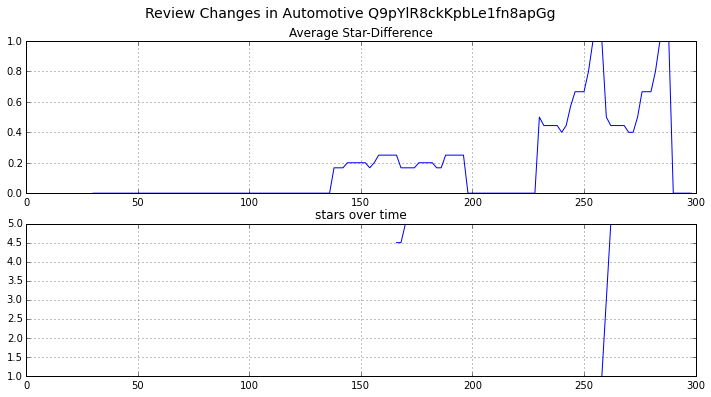

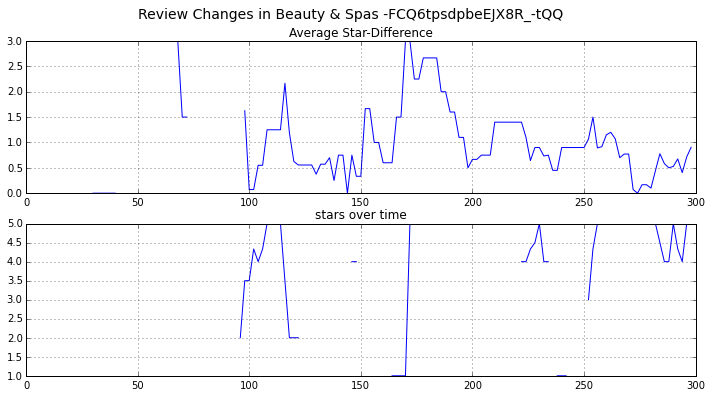

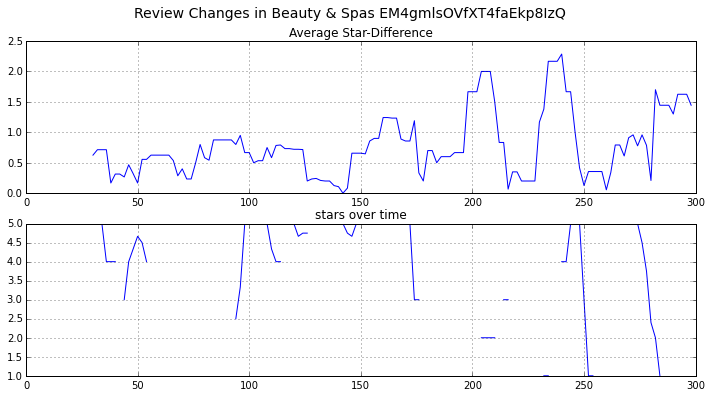

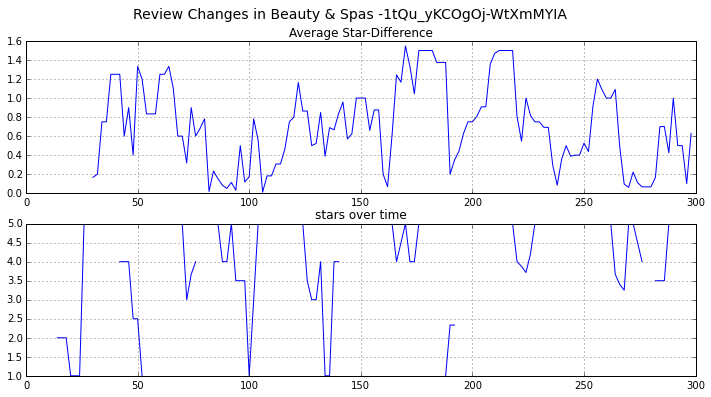

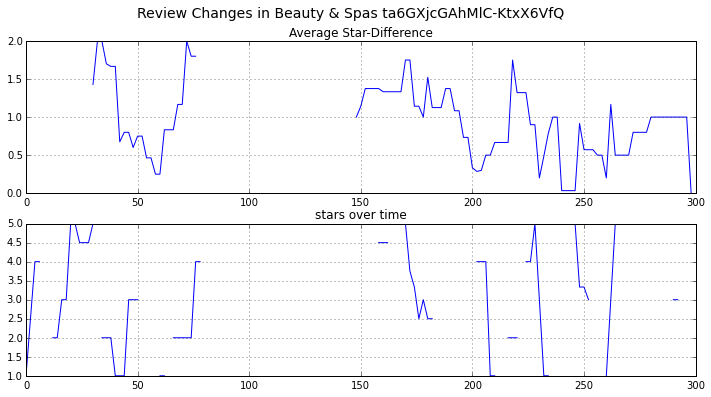

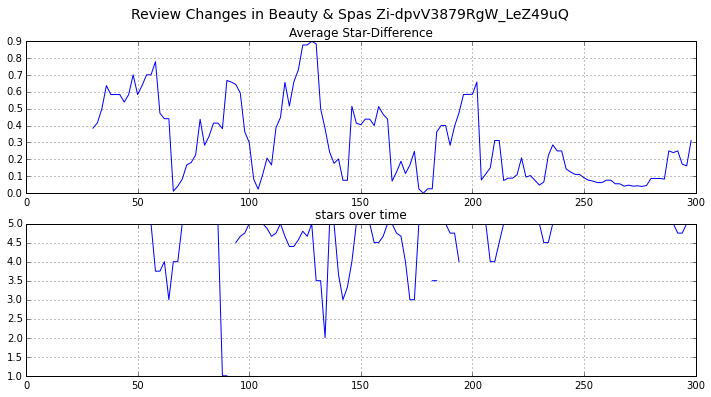

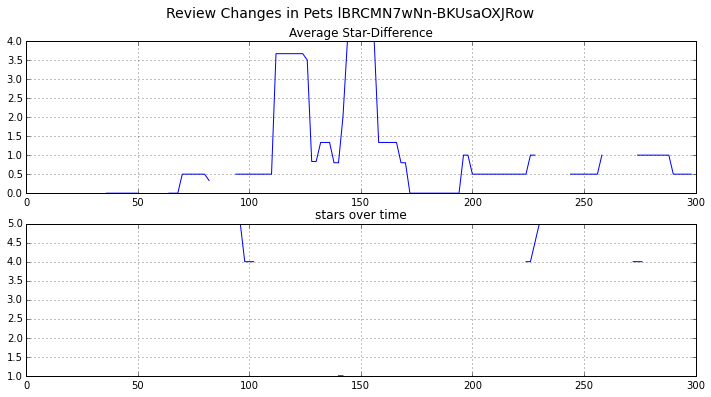

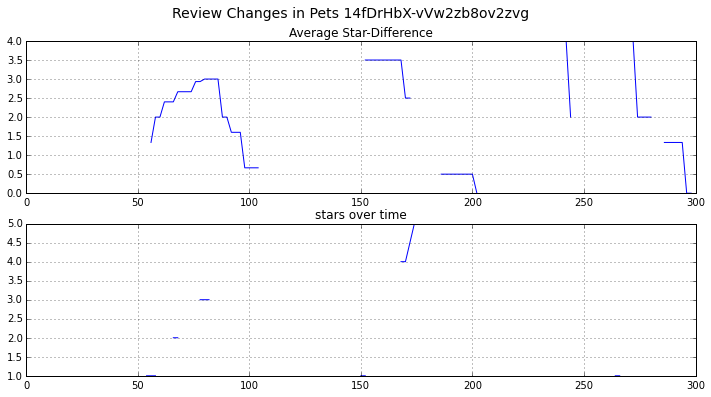

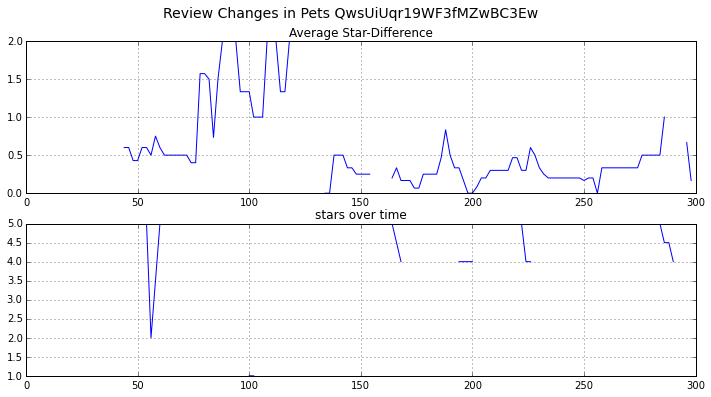

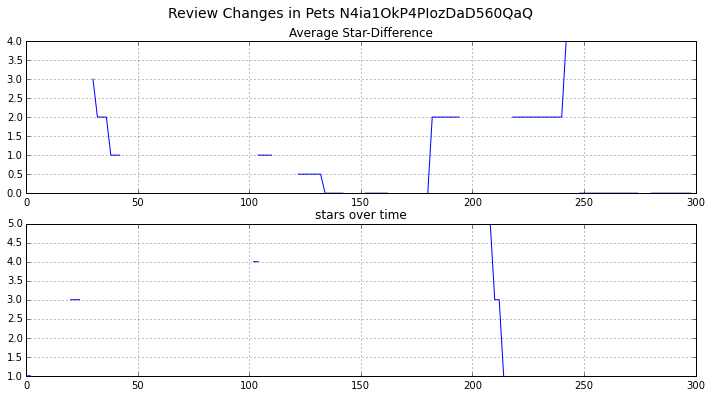

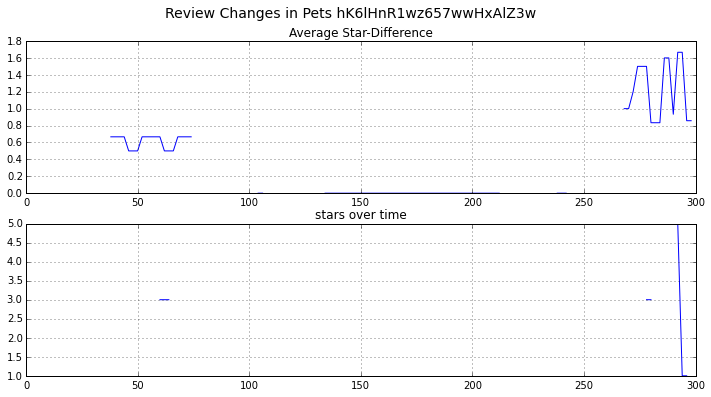

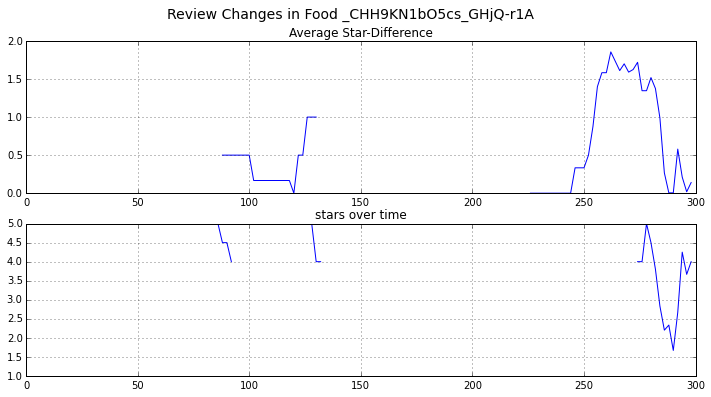

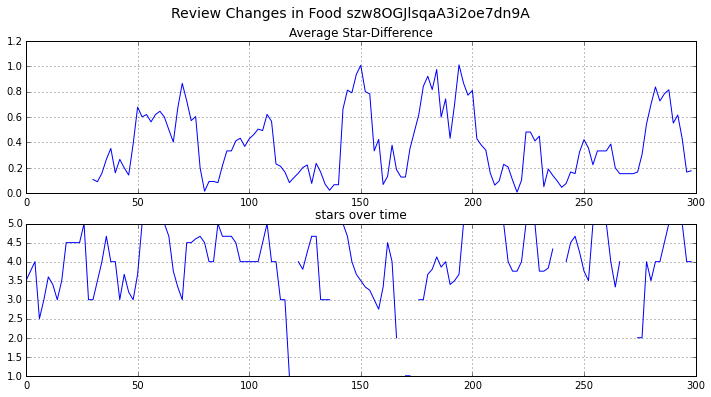

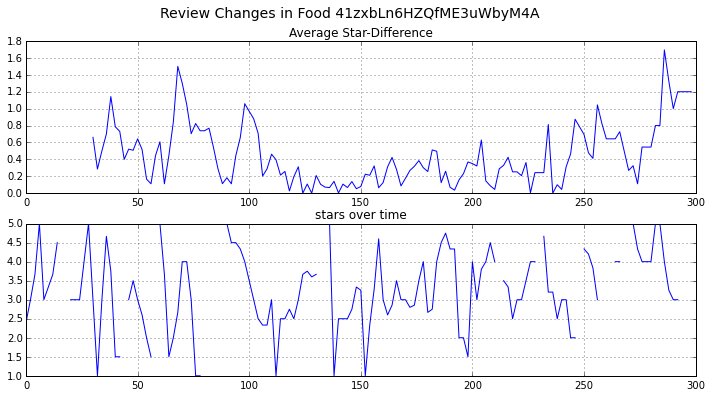

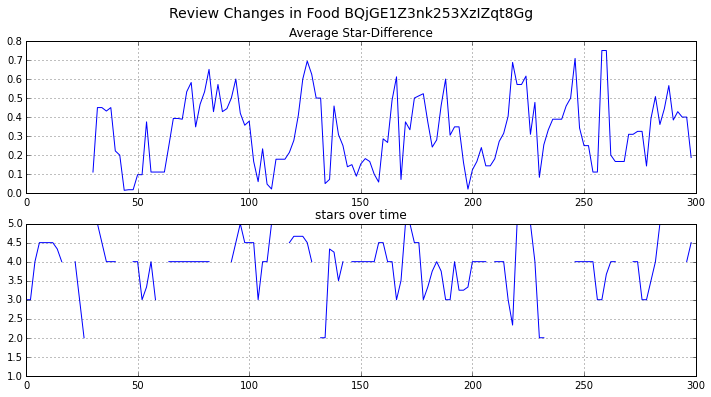

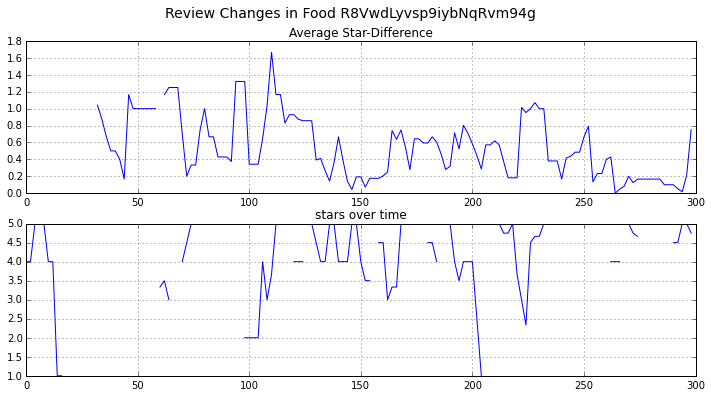

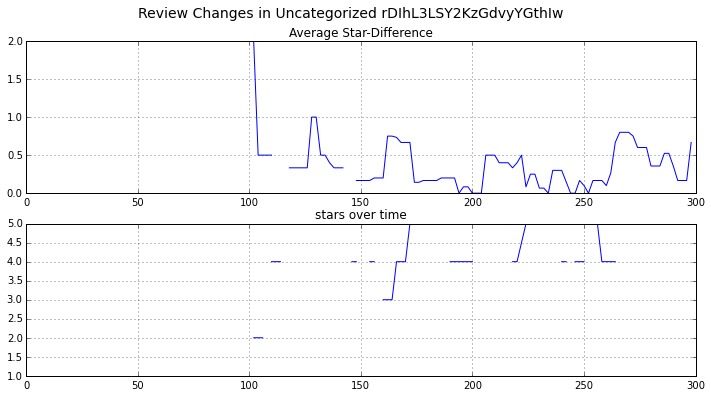

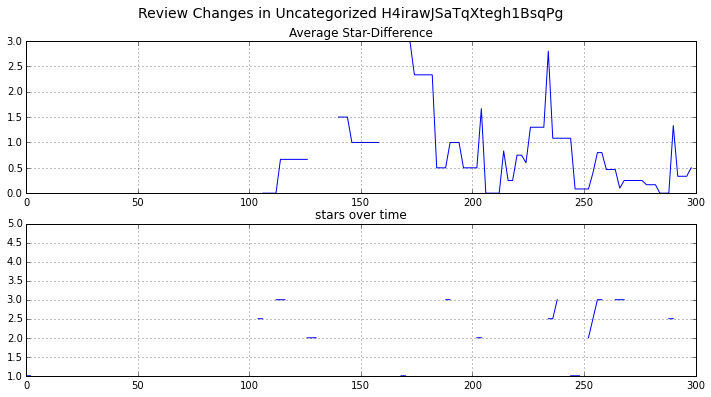

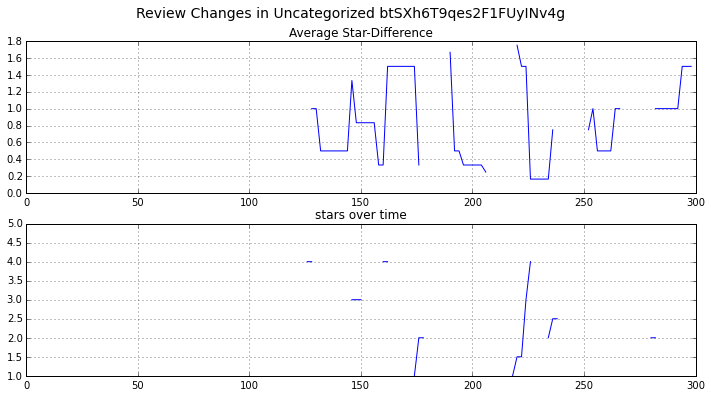

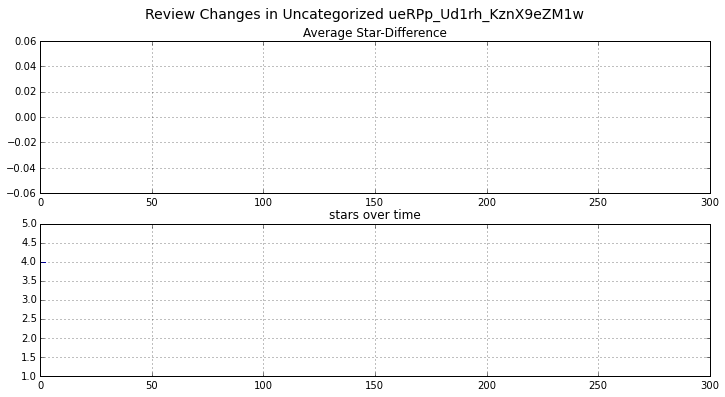

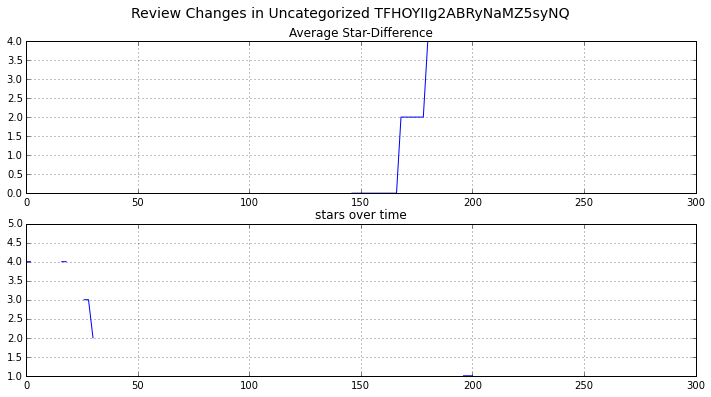

In [213]:
for supercat in box:
    in_supercat = reviews[reviews['super_category'] == supercat]
    for bid in in_supercat['business_id'].value_counts()[:5].index.tolist():
        trash = show_business_review_changes(in_supercat, bid, frame_radius=30, days_back=300, step_width=2,
                                    title= "Review Changes in "
                                           + box[businesses[businesses['business_id'] == bid]\
                                                 ['super_category'].tolist()[0]]['name']
                                           + " " + bid
                                    )

###Assumption
Trend cut with over 0.5 Average Star Difference

No Trends for Uncategorized, Pets

Trend analysis does only make sense with more than 50 reviews

In [13]:
def trend_average(reviews, bid, frame_radius=30, days_back=150, step_width=10):
    business_reviews = reviews[reviews['business_id'] == bid]
    # with less than 50 reviews a trend-analysis does not make sense
    last_review = business_reviews.index.max()
    if business_reviews[business_reviews.index > last_review - dt.timedelta(days=days_back + 2 * frame_radius)]\
            ['business_id'].count() < 50:
        return (days_back, business_reviews['stars'].mean())
    
    steps = range(frame_radius, days_back + 1, step_width)

    cut_days = days_back
    for days_in_past in steps:
        sep_date = last_review - dt.timedelta(days=days_in_past)
        first_frame_border = sep_date + dt.timedelta(days=frame_radius)
        last_frame_border = sep_date - dt.timedelta(days=frame_radius)

        seperation = business_reviews[(business_reviews.index >= sep_date) &
                                                       (business_reviews.index <= first_frame_border)]['stars'].mean() \
            - business_reviews[(business_reviews.index < sep_date) & 
                               (business_reviews.index >= last_frame_border)]['stars'].mean()
        # 0.5 is our random magic number for a relevant trend cut
        if np.abs(seperation) > 0.5:
            days_back = days_in_past
            break
    return (days_back,
            business_reviews[business_reviews.index > last_review - dt.timedelta(days=days_in_past)]['stars'].mean())

In [11]:
max_iterations = 3000

review_cuts = pd.DataFrame()
for supercat in box:
    #if box[supercat]['name'] in ["Pets", "Uncategorized"]:
    #    continue
    print("analyzing {}".format(box[supercat]['name']))
    in_supercat = reviews[reviews['super_category'] == supercat]
    days_in_past = []
    i = 1
    for bid in set(in_supercat['business_id'].tolist()):
        print("iteration {} of {}".format(i, max_iterations), end='\r')
        (this, trash) = trend_average(in_supercat, bid, step_width=5, days_back=150)
        days_in_past.append(this)
        
        # do not iterate all day long
        if i >= max_iterations:
            break
        i = i + 1
        
    review_cuts[box[supercat]['name']] = pd.Series(days_in_past)

analyzing Event Planning & Services
analyzing Shopping
analyzing Home Services
analyzing Beauty & Spas
analyzing Active Life
analyzing Restaurants
analyzing Automotive
analyzing Food
analyzing Pets
analyzing Uncategorized


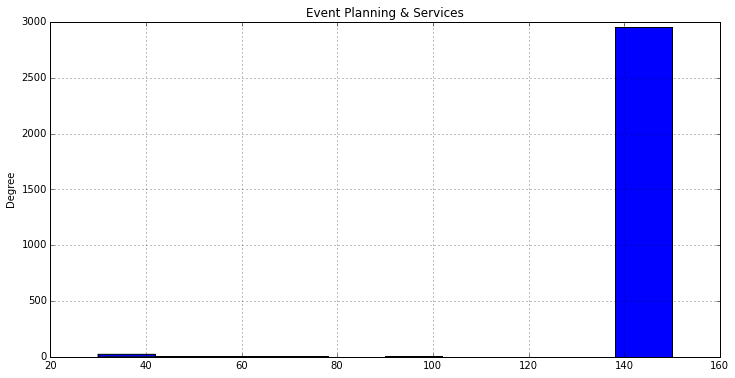

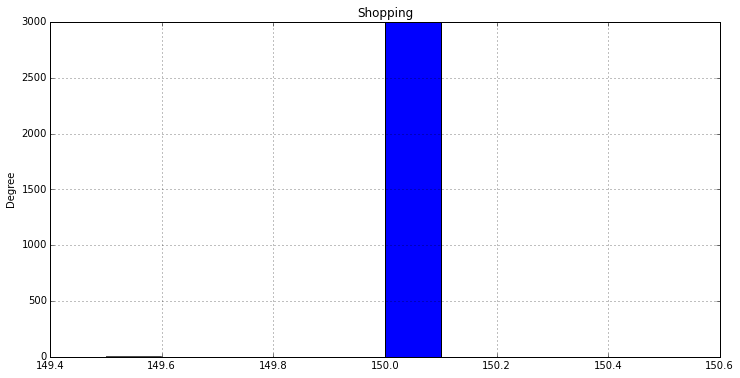

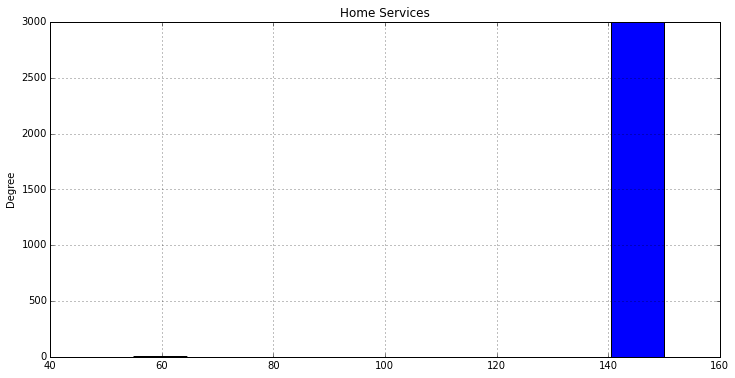

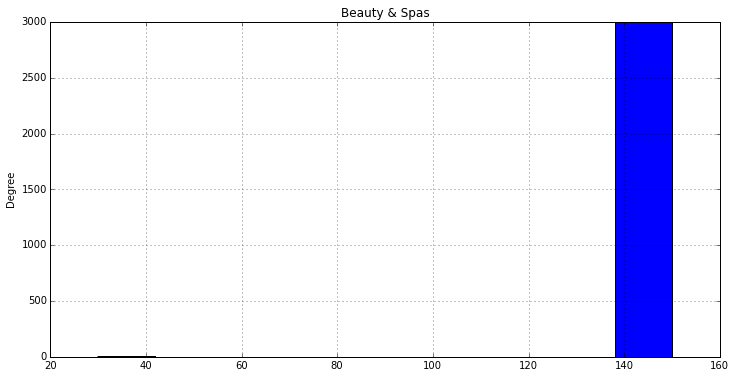

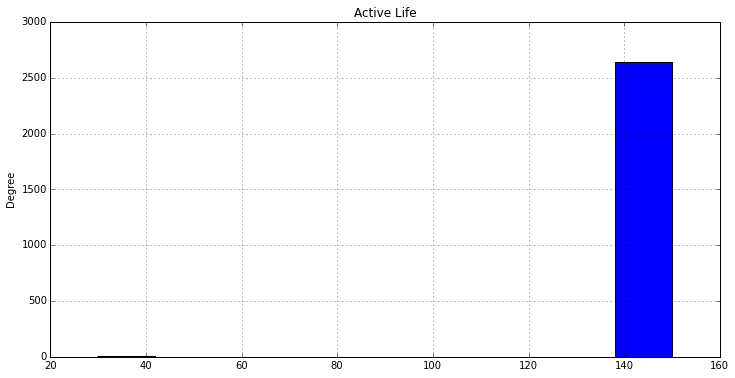

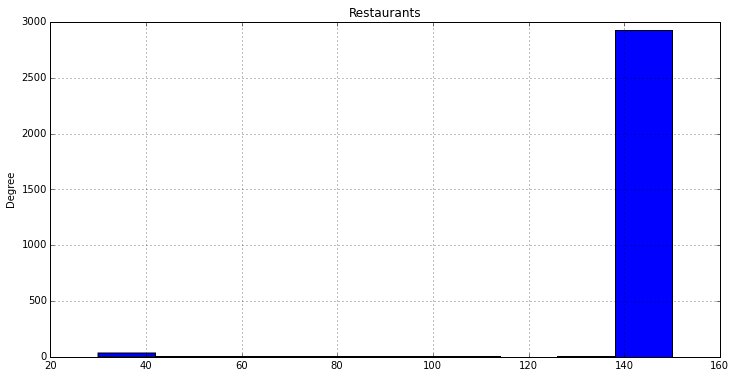

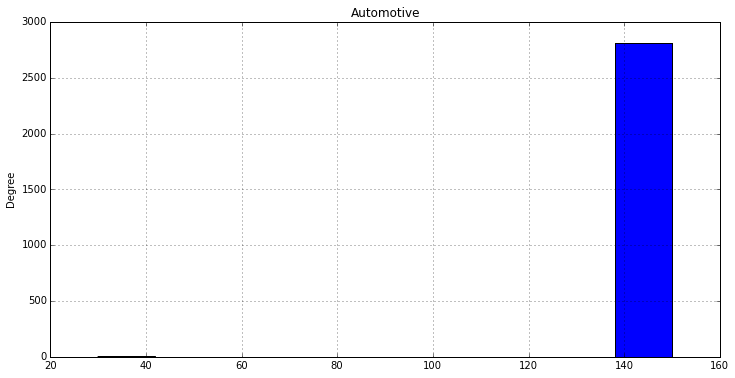

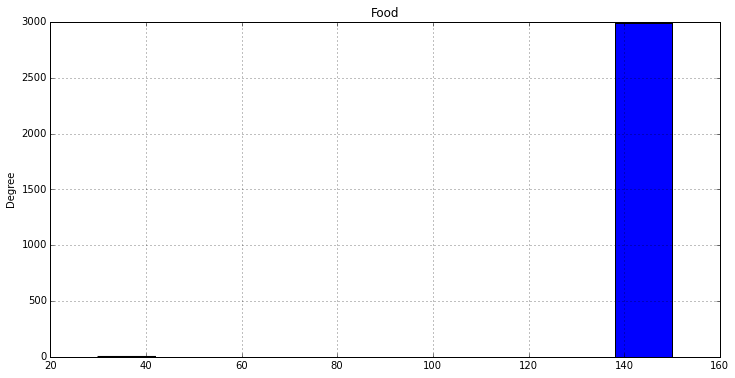

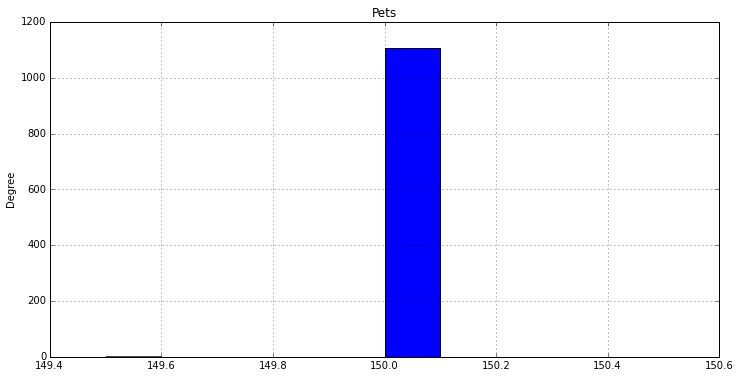

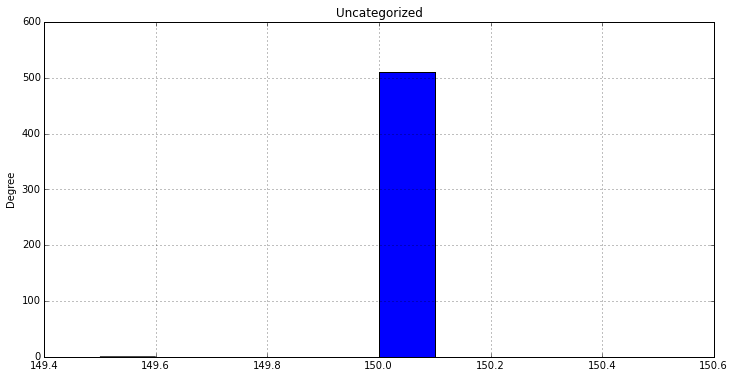

In [12]:
for supercat in review_cuts.columns.values:
    plt.figure()
    plt.title(supercat)
    ax = review_cuts[supercat].plot(kind='hist')
    plt.show()

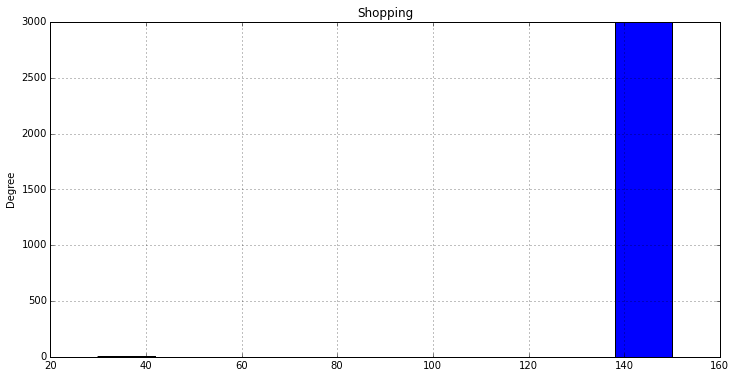

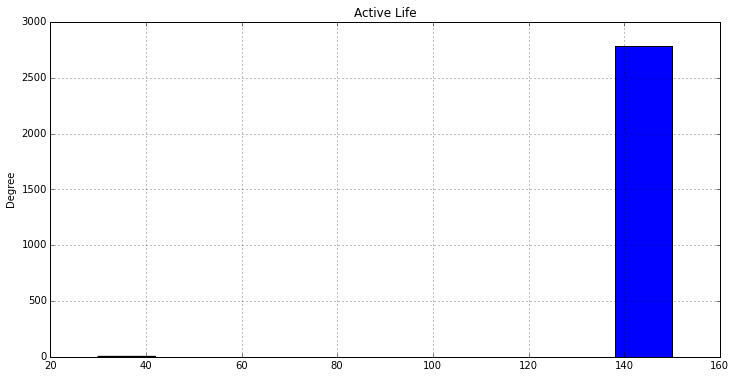

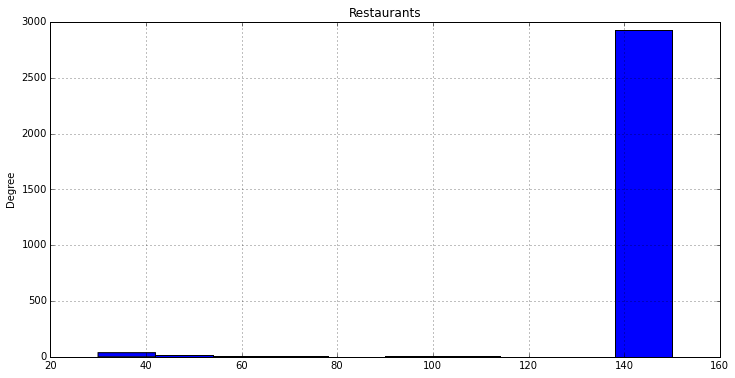

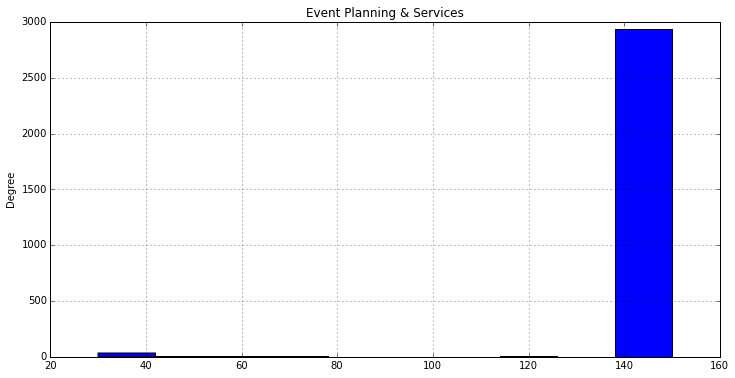

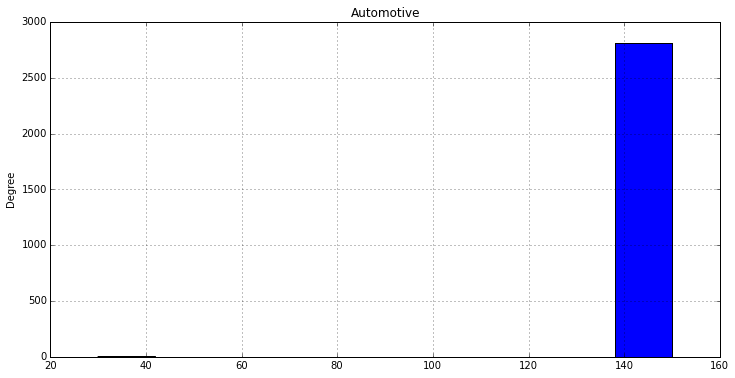

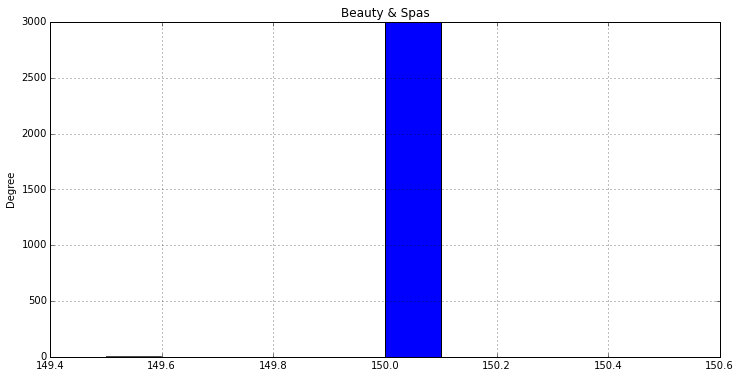

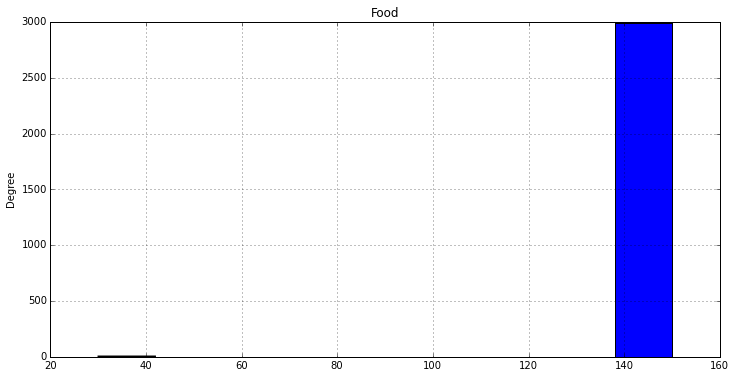

In [218]:
for supercat in review_cuts.columns.values:
    plt.figure()
    plt.title(supercat)
    ax = review_cuts[supercat].plot(kind='hist')
    plt.show()